# Analysis of the Storks Data

The ancient myth of storks delivering babies is discussed to the present day. It has been suggested that the birth rate of a country and number of storks could be tied by confounding variables, such as the land area. In this report, we explore the associations between different variables.

This report aims to construct several regression models and evaluate their performance, relating to the storks data for 17 countries. Two regression models with select variables will be built for the number of births and number of storks respectively. After building the regression models, the bootstrap technique will be used to estimate and comment on the distributions of the difference in R2 parameters for the number of births, and the root mean squared errors (RMSE) for the number of storks. This will allow us to ascertain if one model is better than another, for a given target variable.


## Table of Contents

1. Section 1: Introduction
      1. Describing and Loading the Data
      1. Determining the Population Density and Area of Suitable Land
      
2. Section 2: Linear Regression Models for the Number of Births
      1. Model 1 - Predictions using the Number of Storks
      1. Model 2 -  Predictions using the Population Size
      1. Bootstrapping Both Models for the R2 Coefficient Difference
     
3. Section 3: Linear Regression Models for the Number of Storks
      1. Model 1 - Predictions using the Land Area
      1. Model 2 - Predictions using the Population Density and Suitable Land Area
      1. Bootstrapping Both Models for the RMSE Difference
      
4. Section 4: Conclusion


In [1]:
# Importing the relevant modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample

%matplotlib inline

## Section 1: Introduction

In this section we will introduce the storks dataset and describe the attributes within it. We will also define and add a new attribute to the existing dataset, which will be used for analysis in a later section.

### Section 1.1: Describing and Loading the Data

Storks are common birds across Europe, with the data covering 17 countries from the period 1980-1990. The storks dataset that will be used for analysis contains six variables, which have been described below, alongside their assigned data types.

| Name      |      Description             | Type | 
|:--------------|:-----------------------------|:------:|
|Country   | The name of a country |category|  
|Area       | The land area of a country (km$^{2}$) | continuous | 
|Storks      | The number of stork breeding pairs in a country | continuous |
|Humans           |The human population of a country (10$^{6}$)  | continuous |
|BirthRate     | The human birth rate (10$^{3}$ / year)        | continuous |
|SuitableAreaPercent     | The percentage of land area that is suitable for storks     | continuous |




The data has been loaded and the full dataframe can be seen below.

In [2]:
# Creating a dictionary of types for the categorical data
types_dict_storks = {'Country': 'category'}

# Loading the storks data, with data type as above
storks = pd.read_csv("storks.csv", dtype = types_dict_storks)
storks

,Country,Area,Storks,Humans,BirthRate,SuitableAreaPercent
0,Albania,28750,100,3.2,83,55.68
1,Austria,83860,300,7.6,87,38.34
2,Belgium,30520,1,9.9,118,65.93
3,Bulgaria,111000,5000,9.0,117,57.99
4,Denmark,43100,9,5.1,59,81.46
5,France,544000,140,56.0,774,58.47
6,Germany,357000,3300,78.0,901,59.81
7,Greece,132000,2500,10.0,106,47.31
8,Holland,41900,4,15.0,188,70.96
9,Hungary,93000,5000,11.0,124,75.86


### Section 1.2: Determining the Population Density and Area of Suitable Land

In this subsection we will calculate the population density and area of suitable land for each row (country) in the existing dataset. These will be used in a later section as predictors when building a regression model.

The population density will measure the concentration of human individuals in an area within a specific country, and can be calculated by dividing the human population ('Humans') multiplied by a million, over the corresponding country's land area. We assign these values under a new attribute 'PopulationDensity' which has been added to the dataframe.

The area of suitable land will be calculated by multiplying the country's area by the percentage of land area that is suitable for storks. We assign these values under a new attribute 'SuitableArea' which has been added to the dataframe.

Note that the units of these new attributes will be: human population per km$^2$ of land area for the population density, and km$^2$ for the suitable land area. 

The resulting dataframe is shown below.

In [3]:
# Define a function to calculate the population density for a given row (country)
def determinePopulationDensity(row):
    return row['Humans'] * 10**6 / row['Area']

# Define a function to calculate the suitable area of land for a given row (country)
def determineSuitableArea(row):
    return row['Area'] * row['SuitableAreaPercent'] / 100

# Apply the above functions to the existing dataset, and assign values under new columns (attribute)
storks_density = storks.assign(PopulationDensity = storks.apply(determinePopulationDensity, axis=1))

storks_density = storks_density.assign(SuitableArea = storks_density.apply(determineSuitableArea, axis=1))

storks_density

,Country,Area,Storks,Humans,BirthRate,SuitableAreaPercent,PopulationDensity,SuitableArea
0,Albania,28750,100,3.2,83,55.68,111.304348,16008.000
1,Austria,83860,300,7.6,87,38.34,90.627236,32151.924
2,Belgium,30520,1,9.9,118,65.93,324.377457,20121.836
3,Bulgaria,111000,5000,9.0,117,57.99,81.081081,64368.900
4,Denmark,43100,9,5.1,59,81.46,118.329466,35109.260
5,France,544000,140,56.0,774,58.47,102.941176,318076.800
6,Germany,357000,3300,78.0,901,59.81,218.487395,213521.700
7,Greece,132000,2500,10.0,106,47.31,75.757576,62449.200
8,Holland,41900,4,15.0,188,70.96,357.995227,29732.240
9,Hungary,93000,5000,11.0,124,75.86,118.279570,70549.800


## Section 2: Linear Regression Models for the Number of Births

This section will focus on building two regression models with the number of births (column 'BirthRate') as the target variable. Specifically, we will look at the relationships between two predictors and the target variable: number of storks, population size and number of births respectively.

### Section 2.1: Model 1 - Predictions using the Number of Storks

We will construct a linear regression model using the number of stork breeding pairs as a predictor for the number of births. The outputs of the model are explained below.

In [4]:
# Constructing a linear regression model with predictor as storks and target as births
y = storks.BirthRate
X = np.column_stack(storks.Storks).reshape(-1, 1)

reg = LinearRegression()
reg.fit(X, y)
print('The R2 coefficient of determination is %4.3f' % reg.score(X, y))
beta_Storks = reg.coef_
print('Estimated regression coefficient for Storks is %4.2f' % beta_Storks, 
      'change of birth rate (10^3) per stork breeding pair')

The R2 coefficient of determination is 0.385
Estimated regression coefficient for Storks is 0.03 change of birth rate (10^3) per stork breeding pair


The R2 coefficient refers to the proportion of the variation in the dependent variable (birth rate) that is predictable from the independent variables (number of stork breeding pairs). It ranges from 0 to 1, and the higher the value it indicates a better fit for the model. In our case, the coefficient shows that 38.5% of variation in the birth rate can be explained by the number of storks. This suggests that, although the number of storks cannot predict the birth rate of a country very well, they may have some ability to do so.

The regression coefficient suggests that there is a positive correlation between the number of storks and births - as one increases, so does the other. The fit of the regression model can be seen in the scatter plot below. It shows the actual data  points and the regression line created by the model - we can see the spread of the points from the line. The R2 value suggests that in general the points stray away from the line, which is also clear from the plot.

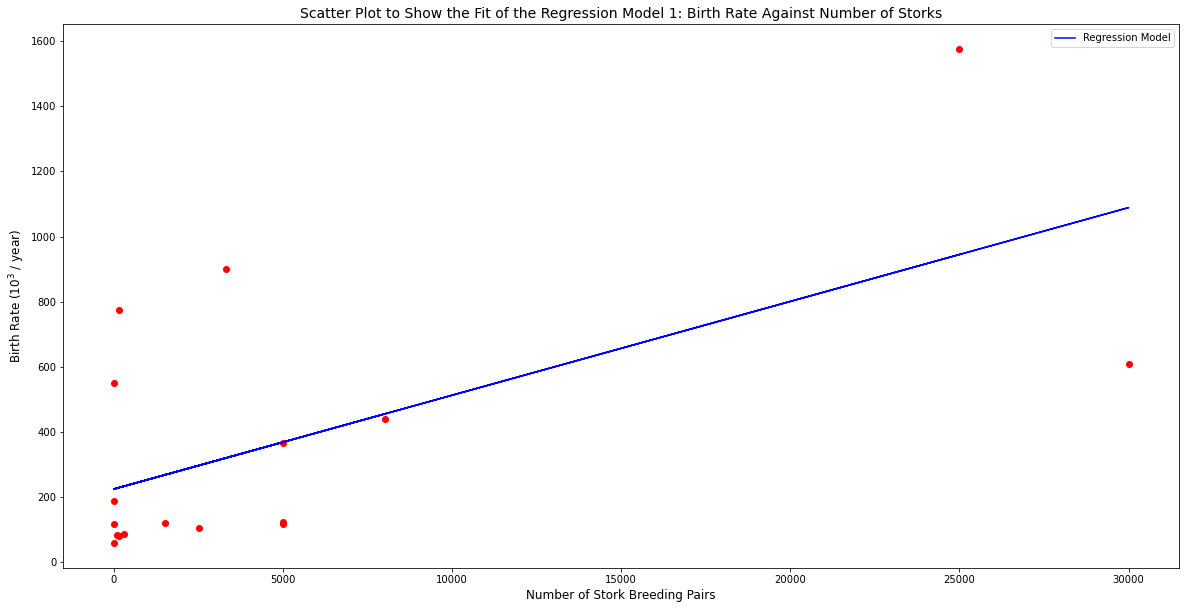

In [5]:
# Finding the predicted values based on the linear regression model
y_hat = reg.predict(X)

# Plotting the actual data points and the regression model
fig, ax = plt.subplots(1,1, figsize=(20,10))

ax.set_title("Scatter Plot to Show the Fit of the Regression Model 1: Birth Rate Against Number of Storks", fontsize=14)
ax.scatter(X, y, color='r')
ax.plot(X, y_hat, label = 'Regression Model', color='b')
ax.set_xlabel("Number of Stork Breeding Pairs", fontsize=12)
ax.set_ylabel("Birth Rate (10$^3$ / year)", fontsize=12)
ax.legend()

### Section 2.2: Model 2 -  Predictions using the Population Size

We will construct a linear regression model using the population size as a predictor for the number of births. The outputs of the model are explained below.

In [6]:
# Constructing a linear regression model with predictor as population size and target as birth rate
y = storks.BirthRate
X = np.column_stack(storks.Humans).reshape(-1, 1)

reg = LinearRegression()
reg.fit(X, y)
print('The R2 coefficient of determination is %4.3f' % reg.score(X, y))
beta_Humans = reg.coef_
print('Estimated regression coefficient for humans is %4.2f' % beta_Humans, 
      'change of birth rate (10^3) per 10^6 humans')

The R2 coefficient of determination is 0.725
Estimated regression coefficient for humans is 14.83 change of birth rate (10^3) per 10^6 humans


The R2 coefficient shows that approximately 72.5% of variation in the birth rate can be explained by the population size. When compared to the R2 coefficient for storks, this shows that the population size appears to be a better predictor of the birth rate. This is also evident from the scatter plot below; the data points are much closer to the regression line than seen for model 1.

The regression coefficient suggests that there is a positive correlation between the population size and births - as one increases, so does the other. This could be expected, as a larger population would naturally lead to a greater birth rate.

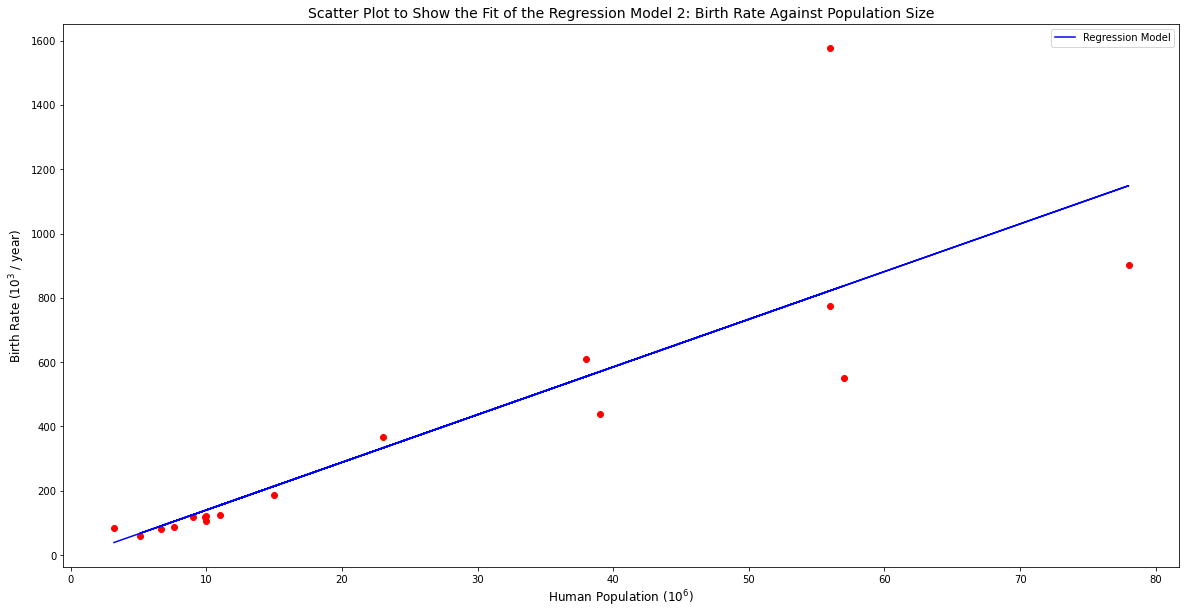

In [7]:
# Finding the predicted values based on the linear regression model
y_hat = reg.predict(X)

# Plotting the actual data points and the regression model
fig, ax = plt.subplots(1,1, figsize=(20,10))

ax.set_title("Scatter Plot to Show the Fit of the Regression Model 2: Birth Rate Against Population Size", fontsize=14)
ax.scatter(X, y, color='r')
ax.plot(X, y_hat, label = 'Regression Model', color='b')
ax.set_xlabel("Human Population (10$^6$)", fontsize=12)
ax.set_ylabel("Birth Rate (10$^3$ / year)", fontsize=12)
ax.legend()

### Section 2.3: Bootstrapping Both Models for the R2 Coefficient Difference

In order to effectively compare the difference between the R2 coefficients for models 1 and 2, we should estimate their sampling distributions. In this subsection we will estimate the sampling distributions of the R2 coefficients for both models, using the bootstrap technique. This method takes a sample (with replacement) of the data, which is the same size as the original but may include repeats and may omit value(s). 

The R2 coefficients using both models are then determined for each resample using similar methods to the above, and the process will be repeated 500 times (to obtain 500 R2 coefficients). The resulting differences (calculated as model 1 - model 2) in the distributions of R2 coefficients will be shown using a histogram.

Text(0.5, 0, 'R2 Coefficient Difference')

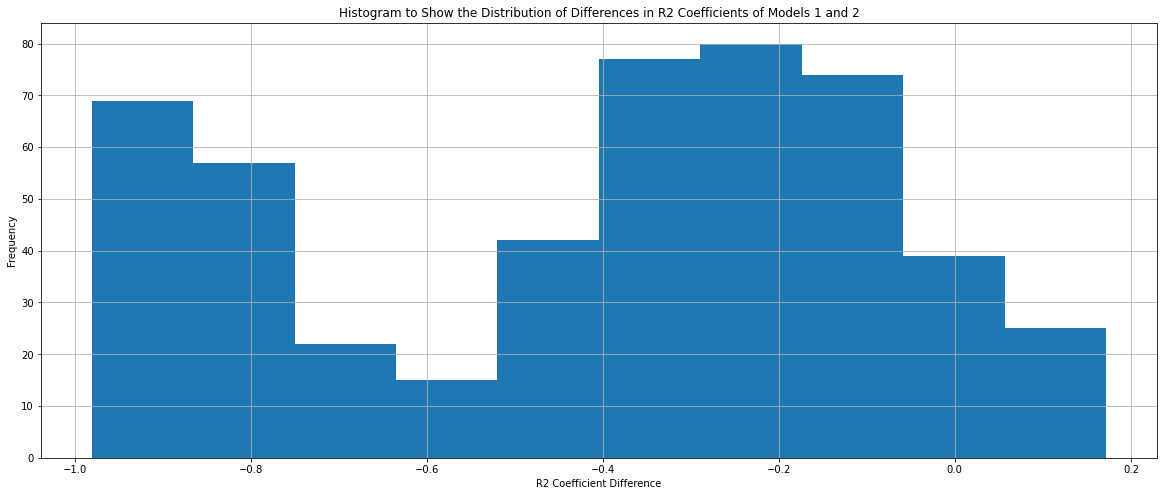

In [8]:
# Define a bootstrapping function, which accepts the dataframe, the output column name, number of repeats and a function
# which returns the value of interest
def bootstrapC(data, cols, repeats, func):
    result = pd.DataFrame(data = dict([(c, np.empty(repeats)) for c in cols]))
    
    for i in range(0, repeats):
        result.iloc[i] = func(resample(data))
    return result

# Define a function that builds a linear regression coefficient for both models, 
# calculates the two R2 values, and then finds the difference between them
def differenceR2(df):
    y = df.BirthRate
    X_model1 = np.column_stack(df.Storks).reshape(-1, 1)
    X_model2 = np.column_stack(df.Humans).reshape(-1, 1)
    reg_model1 = LinearRegression().fit(X_model1, y)
    reg_model2 = LinearRegression().fit(X_model2, y)
    R2_model1 = reg_model1.score(X_model1, y)
    R2_model2 = reg_model2.score(X_model2, y)
    return [R2_model1 - R2_model2]

# Creating a histogram to show the distribution of the differences in R2 values between models 1 and 2
fig, ax = plt.subplots(1,1, figsize=(20,8))
difference_r2 = bootstrapC(storks, ['R2_Difference'], 500, differenceR2) 
difference_r2.hist(ax=ax)
ax.set_title("Histogram to Show the Distribution of Differences in R2 Coefficients of Models 1 and 2")
ax.set_ylabel("Frequency")
ax.set_xlabel("R2 Coefficient Difference")

We can see that most of the R2 coefficient differences show a bimodal distribution; there are peaks around -0.9 and -0.2. It is evident that the majority of differences are less than 0, which suggests that most of the time the resampled R2 coefficient of model 2 is greater than that of model 1.

Furthermore, we can estimate confidence intervals based on this distribution, to see whether or not we can be confident that one of the models explains more of the variability in the number of births than the other model.

In [9]:
# Determining the sample difference, and comparing this to the various confidence intervals obtained from bootstrapping
sampleDiff = differenceR2(storks)[0]
print("The difference between the R2 coefficient (model 1 - model 2) is %3.2f with 80%% CI %3.2f to %3.2f" % 
      (sampleDiff, difference_r2.R2_Difference.quantile(0.1), difference_r2.R2_Difference.quantile(0.9)))
print("The difference between the R2 coefficient (model 1 - model 2) is %3.2f with 90%% CI %3.2f to %3.2f" % 
      (sampleDiff, difference_r2.R2_Difference.quantile(0.05), difference_r2.R2_Difference.quantile(0.95)))
print("The difference between the R2 coefficient (model 1 - model 2) is %3.2f with 99%% CI %3.2f to %3.2f" % 
      (sampleDiff, difference_r2.R2_Difference.quantile(0.005), difference_r2.R2_Difference.quantile(0.995)))

The difference between the R2 coefficient (model 1 - model 2) is -0.34 with 80% CI -0.90 to -0.01
The difference between the R2 coefficient (model 1 - model 2) is -0.34 with 90% CI -0.93 to 0.06
The difference between the R2 coefficient (model 1 - model 2) is -0.34 with 99% CI -0.98 to 0.15


From sections 2.1 and 2.2, we obtained R2 coefficients of 0.385 and 0.725 for models 1 and 2 respectively. The difference between them (in terms of model 1 - model 2) is - 0.34 (to 2 decimal places), which suggests that model 2 produces a better fit. This sample difference falls inside all of the above confidence intervals.

Using the example of the 99% confidence interval - if we were to carry out this experiment with another sample, there would be a 99% chance that the difference in the R2 coefficients would be in the 99% confidence interval (the central 99% of resampled coefficients).

Although the R2 coefficient difference of the sample falls within the 99% and 90% confidence intervals, these ranges also include negative values, zero and positive values consistently, which the population parameter could be. As such there are several possibilities - model 2 explains more of the variability in the number of births, or there is no difference, or that model 1 explains more of the variability in the number of births respectively. Using these intervals we cannot be confident about any of these conclusions.

However, the 80% confidence interval includes only negative values (does not contain zero). However, note that one end of the interval includes values that are very close to zero, which still indicates a difference but may be a small one between the resampled R2 coefficient. Therefore, we can be 80% confident that the R2 coefficient difference would fall in this range and subsequently model 2 would explain more of the variability in the number of births than model 1.

## Section 3: Linear Regression Models for the Number of Storks

This section will focus on building two regression models with the number of storks as the target variable. The first model will feature land area as a predictor, whereas the second model will use the population density and the area of suitable land (which were derived in Section 1).

### Section 3.1: Model 1 - Predictions using the Land Area

We will construct a linear regression model using the land area as a predictor for the number of storks. The outputs of the model are explained below.

In [10]:
# Constructing a linear regression model with predictor as land area and target as storks
y = storks.Storks
X = np.column_stack(storks.Area).reshape(-1, 1)

reg = LinearRegression()
reg.fit(X, y)
print('The R2 coefficient of determination is %4.3f' % reg.score(X, y))
beta_Area = reg.coef_
print('Estimated regression coefficient for Area is %4.2f' % beta_Area, 
      'change in number of breeding pair storks per km^2')

The R2 coefficient of determination is 0.336
Estimated regression coefficient for Area is 0.02 change in number of breeding pair storks per km^2


The R2 coefficient shows that 33.6% of variation in the number of storks can be explained by the land area in a country. This suggests that land area is not a very good predictor for the number of storks.

The regression coefficient suggests that there is a positive correlation between the land area and number of storks - as one increases, so does the other. This could be expected, as a larger land area could potentially inhabit more storks.

The fit of the model is shown in the scatter plot below. We can see that a few of the data points are not close to the regression line.

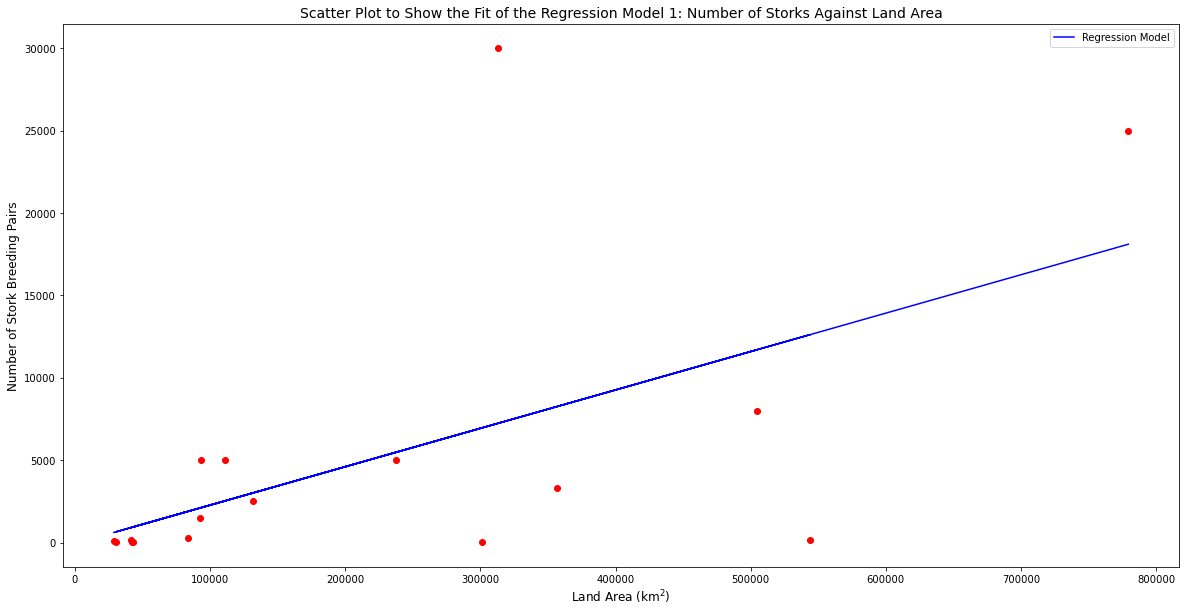

In [11]:
# Finding the predicted values based on the linear regression model
y_hat = reg.predict(X)

# Plotting the actual data points and the regression model
fig, ax = plt.subplots(1,1, figsize=(20,10))

ax.set_title("Scatter Plot to Show the Fit of the Regression Model 1: Number of Storks Against Land Area", fontsize=14)
ax.scatter(X, y, color='r')
ax.plot(X, y_hat, label = 'Regression Model', color='b')
ax.set_xlabel("Land Area (km$^2$)", fontsize=12)
ax.set_ylabel("Number of Stork Breeding Pairs", fontsize=12)
ax.legend()

We can also calculate another metric known as the root mean squared error (RMSE), which similarly to the R2 coefficient, looks at how well the model fits the data. However, unlike the R2 coefficient, it is not fixed to a range of 0 to 1. It tells us about the average distance of the predicted values (using the regression model) from the actual values in the dataset. Therefore, a lower RMSE value would indicate that the model better fits the data as it lies generally closer to the actual data points.

In [12]:
# Calculating the RMSE using the predicted and actual values
print('Root of the mean squared error: %.2f'% mean_squared_error(y, y_hat, squared=False))

Root of the mean squared error: 6984.77


The above RMSE value tells us that the average difference between the predicted number of storks and the actual number of storks is approximately 6985 breeding pairs. Although this value does not directly give a specific interpretation of how "good" the model is, it will enable us to make comparisons against another model (which will be constructed in the following subsection).

### Section 3.2: Model 2 - Predictions using the Population Density and Suitable Land Area

We will construct a linear regression model using the population density and area of suitable land as predictors for the number of storks. The outputs of the model are explained below.

In [13]:
# Constructing a linear regression model with predictors as population density, suitable land area and target as storks
y = storks_density.Storks
X = np.column_stack((storks_density.PopulationDensity, storks_density.SuitableArea))

reg = LinearRegression()
reg.fit(X, y)
print('The R2 coefficient of determination is %4.3f' % reg.score(X, y))
beta_PopDens, beta_SLA = reg.coef_
print('Estimated regression coefficient for population density is %4.2f' % beta_PopDens, 
      'change of number of breeding pair storks per human/km2')
print('Estimated regression coefficient for area of suitable land is %4.2f' % beta_SLA, 
      'change of number of breeding pair storks per percentage suitable area')

The R2 coefficient of determination is 0.393
Estimated regression coefficient for population density is -12.13 change of number of breeding pair storks per human/km2
Estimated regression coefficient for area of suitable land is 0.04 change of number of breeding pair storks per percentage suitable area


The coefficient shows that approximately 39.3% of variation in the number of storks can be explained by the population density and suitable area of land. This is greater than the value obtained for the previous model, but still does not show a great fit. 

The regression coefficient suggests that there is a negative correlation between the population density and number of storks (as one decreases, so does the other). On the other hand, the regression coefficient for area of suitable land suggests a positive correlation coefficient, which may be expected as a country would be able to sustain greater numbers of storks.

Below is a scatter plot to show the fit of the model. Note that as the model has two predictors instead of one, this would result in a plane which is more difficult to visualise. Therefore, instead we have plotted the actual values against the predicted values, which facilitates interpretation of the fit of the model.  We can see that the points generally stray further away from the line when compared to the plot in the previous subsection.

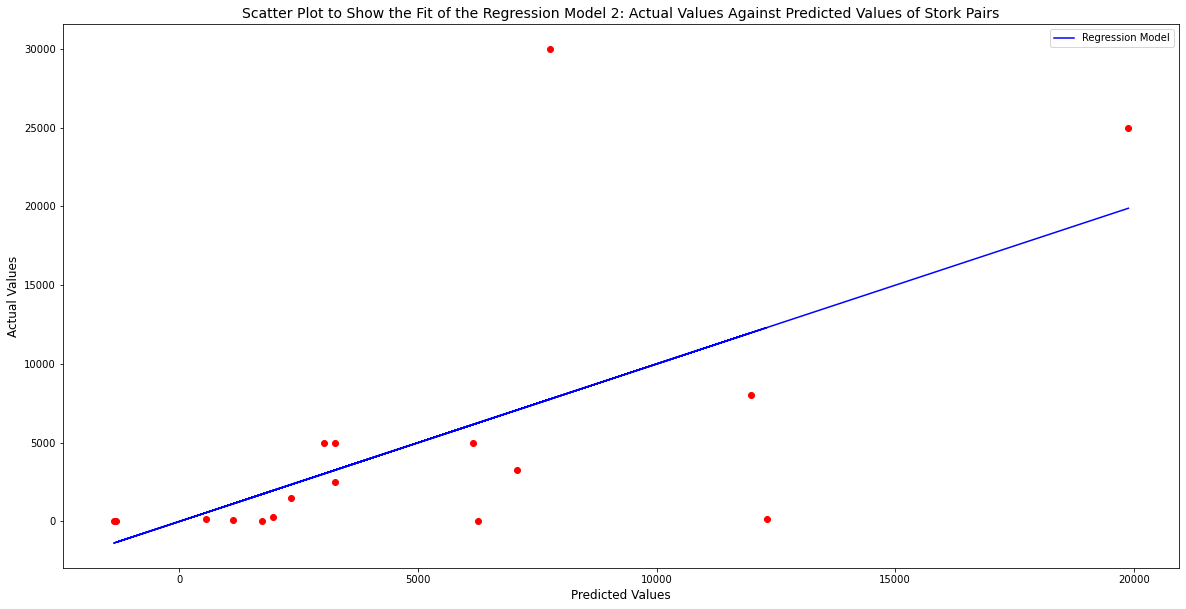

In [14]:
# Finding the predicted values based on the linear regression model
y_hat = reg.predict(X)

# Plotting the actual values against the predicted values
fig, ax = plt.subplots(1,1, figsize=(20,10))

ax.set_title("Scatter Plot to Show the Fit of the Regression Model 2: Actual Values Against Predicted Values of Stork Pairs", fontsize=14)
ax.scatter(y_hat, y, color='r')
ax.plot(y_hat, y_hat, label = 'Regression Model', color='b')
ax.set_xlabel("Predicted Values", fontsize=12)
ax.set_ylabel("Actual Values", fontsize=12)
ax.legend()

Similarly to model 1, we calculate the RMSE for this model below. We can see that this RMSE is lower than that of model 1, which suggests that it is a better model. Furthermore, this is in accordance with the trend in the R2 value, which is higher than that of model 1.

In [15]:
# Calculating the RMSE using the predicted and actual values
print('Root of the mean squared error: %.2f'% mean_squared_error(y, y_hat, squared=False))

Root of the mean squared error: 6677.03


### Section 3.3: Bootstrapping Both Models for the RMSE Difference

In order to effectively compare the difference between the RMSE's for models 1 and 2, we need to estimate their distributions. In this subsection we will estimate the sample distribution of the differences in RMSE's for both models, using the bootstrap technique. This is similar to the methods carried out for the difference in the R2 coefficient in the previous section; we will carry out 500 resamples. The resulting distributions of the differences in RMSE's (model 1 - model 2) will be shown using a histogram.

Text(0.5, 0, 'RMSE Difference')

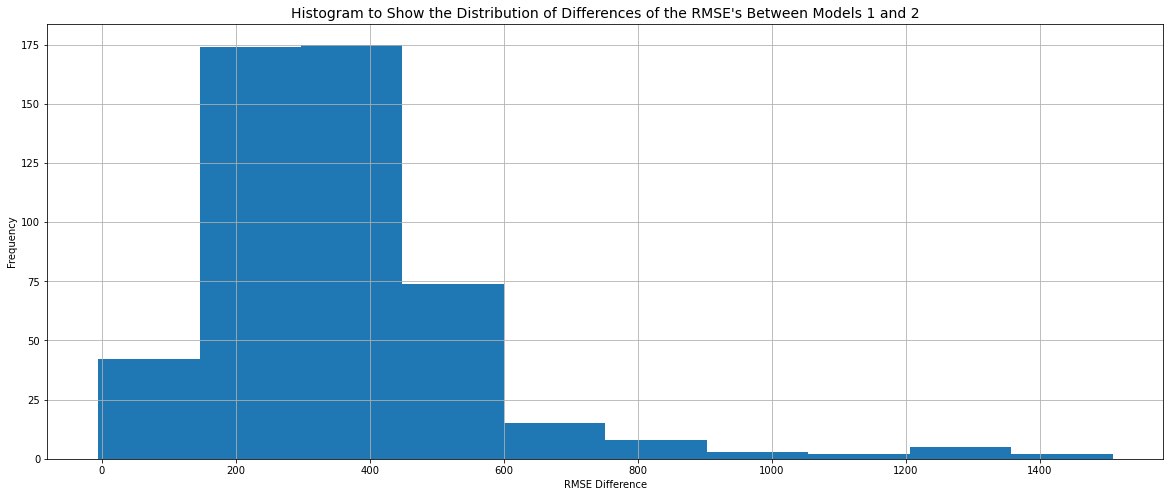

In [16]:
# Define a function that builds a linear regression coefficient for both models, 
# calculates the two RMSE values, and then finds the difference between them
def differenceRMSE(df):
    y = df.Storks
    X_model1 = np.column_stack(df.Area).reshape(-1, 1)
    X_model2 = np.column_stack((df.PopulationDensity, df.SuitableArea))
    reg_model1 = LinearRegression().fit(X_model1, y)
    reg_model2 = LinearRegression().fit(X_model2, y)
    y_hat_model1 = reg_model1.predict(X_model1)
    y_hat_model2 = reg_model2.predict(X_model2)
    RMSE_model1 = mean_squared_error(y, y_hat_model1, squared=False)
    RMSE_model2 = mean_squared_error(y, y_hat_model2, squared=False)
    return [RMSE_model1 - RMSE_model2]

# Creating a histogram to show the distribution of the differences in RMSE values between models 1 and 2
fig, ax = plt.subplots(1,1, figsize=(20,8))
difference_rmse = bootstrapC(storks_density, ['RMSE_Difference'], 500, differenceRMSE) 
difference_rmse.hist(ax=ax)
ax.set_title("Histogram to Show the Distribution of Differences of the RMSE's Between Models 1 and 2", fontsize=14)
ax.set_ylabel("Frequency")
ax.set_xlabel("RMSE Difference")

The distribution of the RMSE differences shows that the resampled RMSE of model 2 is generally better (lower) than model 2. The confidence intervals for this distribution are as follows:

In [17]:
# Determining the sample difference, and comparing this to the various confidence intervals obtained from bootstrapping
sampleDiff = differenceRMSE(storks_density)[0]
print("The difference between the RMSE (model 1 - model 2) is %3.2f with 80%% CI %3.2f to %3.2f" % 
      (sampleDiff, difference_rmse.RMSE_Difference.quantile(0.1), difference_rmse.RMSE_Difference.quantile(0.9)))
print("The difference between the RMSE (model 1 - model 2) is %3.2f with 90%% CI %3.2f to %3.2f" % 
      (sampleDiff, difference_rmse.RMSE_Difference.quantile(0.05), difference_rmse.RMSE_Difference.quantile(0.95)))
print("The difference between the RMSE (model 1 - model 2) is %3.2f with 99%% CI %3.2f to %3.2f" % 
      (sampleDiff, difference_rmse.RMSE_Difference.quantile(0.005), difference_rmse.RMSE_Difference.quantile(0.995)))

The difference between the RMSE (model 1 - model 2) is 307.74 with 80% CI 158.62 to 552.83
The difference between the RMSE (model 1 - model 2) is 307.74 with 90% CI 115.46 to 678.79
The difference between the RMSE (model 1 - model 2) is 307.74 with 99% CI 51.64 to 1311.40


From sections 3.1 and 3.2, we obtained sample RMSE's of 6984.77 and 6677.03 for models 1 and 2 respectively. The difference between them (in terms of model 1 - model 2) is 307.74, which suggests that model 2 is a better predictor of the number of storks than model 1. The sample difference falls inside all of the confidence intervals, all of which only include positive values (greater than 0).

Therefore, we can be 99% confident that model 2 better predicts the number of storks than model 1, as the confidence interval shows that 99% of the resampled RMSE differences would lie in the range; the resampled RMSE differences would be lower for model 2, indicating a better fit.

## Section 4: Conclusion

We have summarised the findings of this report below:
* Linear regression models were constructed for two target variables: the number of births and storks in a country.
* The differences in R2 and RMSE values were explored using the bootstrap method and the resulting confidence intervals.
* Two linear regression models were built to predict the number of human births in a country. Whilst both showed positive  correlations against the target variable, the population size was shown to be a better predictor than the number of storks based on the R2 values in accordance with the 80% confidence interval.
* From a causal perspective, it may be obvious that the population size would directly affect the birth rate. Whereas, the increase in the number of storks with birth rate may be explained by land area as a confounding variable.
* Two linear regression models were built to predict the number of storks in a country. Whilst the land area (and suitable land area) showed a positive correlation, the human population density showed a negative correlation. The second model showed a smaller sample RMSE, and was shown to be a better predictor for the number of storks in accordance with the 99% confidence interval.
* From a causal perspective, it may be expected that the land area/suitable land area could sustain greater numbers of storks. The area of suitable land for storks would naturally seem to be a better predictor for the number of storks, than just general land area (which would have less potential to inhabit storks). In contrast, the link between population density and number of storks is not as clear - perhaps a greater population density could mean less 'space' and resource for storks.
